# 1 Source Code

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import pandas as pd
from time import time

## 1.1 Kmeans

In [24]:
def initialize_centers(X, k):
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def assign_clusters(X, centers):
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centers, axis=1)
        labels[i] = np.argmin(distances)
    return labels

def update_centers(X, labels, k):
    centers = np.zeros((k, X.shape[1]))
    for i in range(k):
        points_in_cluster = X[labels == i]
        if len(points_in_cluster) > 0:
            centers[i] = np.mean(points_in_cluster, axis=0)
    return centers

def calculate_inertia(X, labels, centers):
    inertia = 0
    for i in range(len(X)):
        center = centers[labels[i]]
        inertia += np.sum((X[i] - center) ** 2)
    return inertia

def kmeans(X, k, max_iter=100, tol=1e-4):
    centers = initialize_centers(X, k)
    for _ in range(max_iter):
        old_centers = centers.copy()

        labels = assign_clusters(X, centers)

        centers = update_centers(X, labels, k)

        if np.all(np.linalg.norm(centers - old_centers, axis=1) < tol):
            break


    inertia = calculate_inertia(X, labels, centers)
    return centers, labels, inertia

In [25]:
# def compute_d(X, centers):
#     m = X.shape[0]
#     d = np.zeros(m)
#     for i in range(m):
#         distances = np.linalg.norm(centers - X[i], axis=1) ** 2
#         d[i] = np.min(distances)
#     return d

In [26]:
# def compute_S2(point, X, d):
#     distances = np.linalg.norm(X - point, axis=1) ** 2
#     S2 = X[distances < d]
#     return S2

In [27]:
# def algorithm_3(X, centers):
#     d = compute_d(X, np.array(centers))
#     L = X[np.any([np.linalg.norm(X - x, axis=1) ** 2 < d for x in X], axis=0)]

#     f_k_values = []
#     center_candidates = []

#     for a_i in L:
#         S2_a_i = compute_S2(a_i, X, d)
#         center = np.mean(S2_a_i, axis=0) if len(S2_a_i) > 0 else a_i
#         f_k_value = compute_fk(X, centers + [center])

#         f_k_values.append(f_k_value)
#         center_candidates.append(center)

#     best_index = np.argmin(f_k_values)
#     best_center = center_candidates[best_index]

#     while True:
#         S2_best_center = compute_S2(best_center, X, d)
#         new_center = np.mean(S2_best_center, axis=0) if len(S2_best_center) > 0 else best_center
#         if np.allclose(new_center, best_center):
#             break
#         best_center = new_center

#     return centers + [best_center]

## 1.2 Modified Global Kmeans

In [6]:
def compute_fk(X, centers):
    centers = np.array(centers)
    distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2) ** 2
    min_distances = np.min(distances, axis=1)
    fk_value = np.mean(min_distances)
    return fk_value

In [7]:
def compute_d(X, centers):
    distances = np.linalg.norm(X[:, np.newaxis, :] - centers, axis=2) ** 2
    return np.min(distances, axis=1)

In [8]:
def compute_b_j(data, d):
    b_values = []
    for j in range(len(data)):
        b_j = np.sum(np.maximum(0, d - np.linalg.norm(data - data[j], axis=1) ** 2))
        b_values.append(b_j)
    return np.array(b_values)

In [9]:
def compute_S2(point, X, d):
    distances = np.linalg.norm(X - point, axis=1) ** 2
    return X[distances < d]


In [10]:
def algorithm_3(X, centers):
    d = compute_d(X, np.array(centers))
    distances = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2) ** 2
    L_mask = np.any(distances < d[:, np.newaxis], axis=0)
    L = X[L_mask]
    f_k_values = []
    center_candidates = []

    for a_i in L:
        S2_a_i = compute_S2(a_i, X, d)
        center = np.mean(S2_a_i, axis=0) if len(S2_a_i) > 0 else a_i
        f_k_value = compute_fk(X, np.array(centers + [center]))
        f_k_values.append(f_k_value)
        center_candidates.append(center)

    best_index = np.argmin(f_k_values)
    best_center = center_candidates[best_index]

    while True:
        S2_best_center = compute_S2(best_center, X, d)
        new_center = np.mean(S2_best_center, axis=0) if len(S2_best_center) > 0 else best_center
        if np.allclose(new_center, best_center, atol=1e-6):
            break
        best_center = new_center

    return centers + [best_center]

In [11]:
def mgkm(X, clusters):
    k = 1
    initial_center = np.mean(X, axis=0)
    centers = [initial_center]

    while k < clusters:
        k += 1
        centers = algorithm_3(X, centers)
        kmeans = KMeans(n_clusters=k, init=np.array(centers), n_init=1, max_iter=100, tol=1e-4)
        kmeans.fit(X)
        centers = kmeans.cluster_centers_.tolist()
        labels = kmeans.labels_

    return centers , labels

In [12]:
def algorithm_4(X, n_clusters, tolerance=0.05):
    centers = [np.mean(X, axis=0)]
    fk_values = [compute_fk(X, centers)]

    for k in range(2, n_clusters + 1):
        new_centers = algorithm_3(X, centers)
        centers = new_centers
        centers_array = np.array(centers)

        # Run on Kmeans
        kmeans = KMeans(n_clusters=k, init=centers_array, n_init=1, max_iter=300, random_state=0)
        kmeans.fit(X)
        centers = kmeans.cluster_centers_.tolist()
        # Calculate fk values
        fk = compute_fk(X, centers)
        fk_values.append(fk)

        # Stop....
        if len(fk_values) > 1 and (fk_values[-2] - fk_values[-1]) / fk_values[0] < tolerance:
            break

    return centers, fk_values[-1]



In [13]:
def global_kmeans(data, k):
    m, n = data.shape
    centers = [data.mean(axis=0)]  # Initialize centers with the mean of the data

    for q in range(2, k+1):
        best_centers = None
        best_obj_value = float('inf')

        for candidate in data:
            trial_centers = np.vstack([centers, candidate])
            kmeans = KMeans(n_clusters=q, init=trial_centers, n_init=1)
            kmeans.fit(data)
            final_centers = kmeans.cluster_centers_
            obj_value = compute_fk(data, final_centers)

            if obj_value < best_obj_value:
                best_obj_value = obj_value
                best_centers = final_centers

        centers = best_centers

    return np.array(centers)

In [14]:
def custom_kmeans_best_inertia(data, num_clusters):
    n_samples, n_features = data.shape
    initial_centers = []

    # Step 1: Initial cluster with all data
    center = np.mean(data, axis=0)
    initial_centers.append(center)

    for k in range(1, num_clusters):
        # Step 2: Compute distances from current center
        distances = np.linalg.norm(data - initial_centers[-1], axis=1)
        farthest_point_idx = np.argmax(distances)
        r = distances[farthest_point_idx]
        r_bar = np.mean(distances)
        r_new = (r + r_bar) / 2
        outer_points = data[distances > r_new]

        if len(outer_points) == 0:
            break

        best_inertia = float('inf')
        best_center = None

        for candidate_center in outer_points:
            temp_centers = initial_centers + [candidate_center]
            kmeans = KMeans(n_clusters=len(temp_centers), init=np.array(temp_centers),
                            n_init=1, max_iter=1, random_state=42)
            kmeans.fit(data)
            if kmeans.inertia_ < best_inertia:
                best_inertia = kmeans.inertia_
                best_center = candidate_center

        initial_centers.append(best_center)

    kmeans = KMeans(n_clusters=num_clusters, init=np.array(initial_centers), n_init=1, max_iter=300, random_state=42)
    kmeans.fit(data)

    return kmeans.cluster_centers_, kmeans.labels_


In [28]:
def fast_gkm(data, k):
    """اجرای الگوریتم Fast GKM."""
    centers = []

    centers.append(np.mean(data, axis=0))

    for current_k in range(2, k + 1):
        d_k_minus_1 = compute_d(data, np.array(centers))

        b_values = compute_b_j(data, d_k_minus_1)
        new_center = data[np.argmax(b_values)]
        centers.append(new_center)

        kmeans = KMeans(n_clusters=current_k, init=np.array(centers), n_init=1, max_iter=300)
        kmeans.fit(data)
        centers = kmeans.cluster_centers_.tolist()

    return np.array(centers), kmeans.labels_

In [15]:
# def mgkm(X, clusters):
#     k = 1
#     initial_center = np.mean(X, axis=0)
#     centers = [initial_center]

#     while k < clusters:
#         k += 1
#         centers = algorithm_3(X, centers)
#         kmeans = KMeans(n_clusters=k, init=np.array(centers), n_init=1)
#         kmeans.fit(X)
#         centers = kmeans.cluster_centers_.tolist()  # Convert back to list for consistency
#         labels = kmeans.labels_

#     return centers , labels

In [16]:
def test_mgkm(x, f_opt,k_values):
    z = []
    for i,k in enumerate(k_values):
        a = []
        a.append(k)
        time1 = time() # Starting time
        centers,_ = mgkm(x, k)
        time2 = time() # End of time
        t_time = time2 - time1
        f_bar = compute_fk(x, centers) * len(x) # calculate f bar
        a.append(f_opt[i])
        e = abs((((f_bar - f_opt[i]) / f_opt[i]) * 100).round(2)) # calculate E
        a.append(e)
        a.append(t_time)
        z.append(a)

    df = pd.DataFrame(data=z, columns=['K', 'Optimume', 'E', 'time'])
    return df

In [17]:
def test_km (x , f_opt , k_values) :
    z = []
    for i,k in enumerate(k_values):
        a = []
        a.append(k)
        time1 = time() # Starting time
        centers , _ ,_= kmeans(x, k)
        time2 = time() # End of time
        t_time = time2 - time1
        f_bar = compute_fk(x, centers) * len(x) # calculate f bar
        a.append(f_opt[i])
        e = abs((((f_bar - f_opt[i]) / f_opt[i]) * 100).round(2)) # calculate E
        a.append(e)
        a.append(t_time)
        z.append(a)

    df = pd.DataFrame(data=z , columns=['K' ,'Optimume', 'E' , 'time'])
    return df

In [18]:
def test_gkm (x , f_opt , k_values) :
    z = []
    for i,k in enumerate(k_values):
        a = []
        a.append(k)
        time1 = time() # Starting time
        centers = global_kmeans(x, k)
        time2 = time() # End of time
        t_time = time2 - time1
        f_bar = compute_fk(x, centers) * len(x) # calculate f bar
        a.append(f_opt[i])
        e = abs((((f_bar - f_opt[i]) / f_opt[i]) * 100).round(2)) # calculate E
        a.append(e)
        a.append(t_time)
        z.append(a)

    df = pd.DataFrame(data=z , columns=['K' ,'Optimume', 'E' , 'time'])
    return df

In [19]:
def test_custom (x , f_opt , k_values) :
    z = []
    for i,k in enumerate(k_values):
        a = []
        a.append(k)
        time1 = time() # Starting time
        centers,_ = custom_kmeans_best_inertia(x, k)
        time2 = time() # End of time
        t_time = time2 - time1
        f_bar = compute_fk(x, centers) * len(x) # calculate f bar
        a.append(f_opt[i])
        e = abs((((f_bar - f_opt[i]) / f_opt[i]) * 100).round(2)) # calculate E
        a.append(e)
        a.append(t_time)
        z.append(a)

    df = pd.DataFrame(data=z , columns=['K' ,'Optimume', 'E' , 'time'])
    return df

In [29]:
def test_fast (x , f_opt , k_values) :
    z = []
    for i,k in enumerate(k_values):
        a = []
        a.append(k)
        time1 = time() # Starting time
        centers,_ = fast_gkm(x, k)
        time2 = time() # End of time
        t_time = time2 - time1
        f_bar = compute_fk(x, centers) * len(x) # calculate f bar
        a.append(f_opt[i])
        e = abs((((f_bar - f_opt[i]) / f_opt[i]) * 100).round(2)) # calculate E
        a.append(e)
        a.append(t_time)
        z.append(a)

    df = pd.DataFrame(data=z , columns=['K' ,'Optimume', 'E' , 'time'])
    return df

In [20]:
def d2_plot(label , center , df):
  plt.figure(figsize=(10, 6))
  for cluster in np.unique(label):
      cluster_points = df[label == cluster]
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

  centers_array = np.array(center)
  plt.scatter(centers_array[:, 0], centers_array[:, 1], c='black', marker='x', s=100, label='Centers')

  plt.xlabel(f'Feature 2')
  plt.ylabel(f'Feature 1')
  plt.title('2D Visualization of Clusters MS-Kmeans for K from Algorithm 4')
  plt.legend()
  plt.show()

In [21]:
def d3_plot(label, center, df):
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')
  centers_array = np.array(center)
  for cluster in np.unique(label):
      cluster_points = df[label == cluster]
      # Check if the data has 3 dimensions, otherwise plot only 2
      if df.shape[1] >= 3:
          ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster}')
      else:
          ax.scatter(cluster_points[:, 0], cluster_points[:, 1],  label=f'Cluster {cluster}')  # Plot only 2 dimensions

  # Similarly for centers
  if df.shape[1] >= 3:
      ax.scatter(centers_array[:, 0], centers_array[:, 1], centers_array[:, 2], c='black', marker='x', s=100, label='Centers')
  else:
      ax.scatter(centers_array[:, 0], centers_array[:, 1], c='black', marker='x', s=100, label='Centers')


  ax.set_xlabel(f'Feature 1')
  ax.set_ylabel(f'Feature 2')
  ax.set_zlabel(f'Feature 3')
  ax.set_title('3D Visualization of Clusters MS-Kmeans for K from Algorithm 4')
  ax.legend()
  plt.show()

In [22]:
k_values1 = [2, 3, 4, 5, 6, 7, 8, 9, 10] # k_values for IRIS Dataset
k_values2 = [2, 5, 10, 15, 20, 25, 30, 40, 50] # k_values for (Breast / Liver/Heart Disease) Datasets
k_values3 = [2, 10, 20, 30, 40, 50, 60, 80, 100] # k_values for (Image Segmantation / TSPLIB1060 / TSPLIB3038) Datasets

# 2) IRIS



### 2.1 MGKM
This code uses the Iris dataset to perform Multi-Granularity K-Means (MGKM) clustering. It first loads the Iris data and then runs the MGKM algorithm using pre-calculated optimal objective function values and a range of cluster numbers (k). The final results are stored in the iris_df_mgkm variable and displayed at the end.

In [30]:
iris = load_iris().data
iris_f_opt = [
    152.348, # k = 2
    78.851, # k = 3
    57.228, # k = 4
    46.446, # k = 5
    39.040, # k = 6
    34.298, # k = 7
    29.989, # k = 8
    27.786, # k = 9
    25.834  # k = 10
    ]
iris_df_mgkm = test_mgkm(iris,iris_f_opt , k_values1)
iris_df_mgkm

,K,Optimume,E,time
0,2,152.348,0.00,0.071373
1,3,78.851,0.01,0.039759
2,4,57.228,0.05,0.057034
3,5,46.446,0.54,0.083503
4,6,39.040,1.44,0.100527
5,7,34.298,3.17,0.149800
6,8,29.989,1.71,0.148198
7,9,27.786,2.85,0.174137
8,10,25.834,3.56,0.198540


showing the performance of a modified global k-means clustering algorithm when applied to the Iris dataset. The plot highlights how the computation time and the quality of the clustering results (measured by an objective function) change as the number of clusters used in the algorithm varies. This visualization helps to assess the effectiveness and efficiency of the algorithm for different numbers of clusters on the Iris dataset.

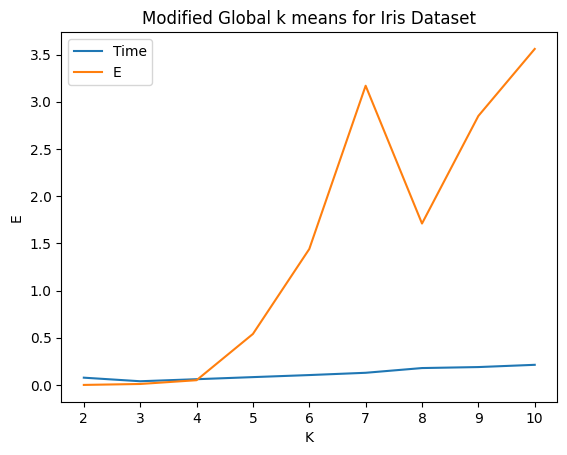

In [ ]:
plt.plot(iris_df_mgkm['K'], iris_df_mgkm['time'], label='Time')
plt.plot(iris_df_mgkm['K'], iris_df_mgkm['E'], label='E')
plt.title('Modified Global k means for Iris Dataset')
plt.xlabel('K')
plt.ylabel('E')
plt.legend()
plt.show()

### 2.2 MS Kmeans

In [ ]:
iris_df_mskm = test_km(iris,iris_f_opt , k_values1)
for i in range (1,200) :
    iris_df_mskm+= test_km(iris,iris_f_opt , k_values1)

iris_df_mskm = iris_df_mskm/200
iris_df_mskm

,K,Optimume,E,time
0,2.0,152.348,0.00000,0.010451
1,3.0,78.851,13.47865,0.014949
2,4.0,57.228,10.90620,0.018921
3,5.0,46.446,12.92540,0.017381
4,6.0,39.040,18.37810,0.018992
5,7.0,34.298,17.39040,0.018314
6,8.0,29.989,20.55770,0.019170
7,9.0,27.786,19.70715,0.018851
8,10.0,25.834,19.84620,0.019336


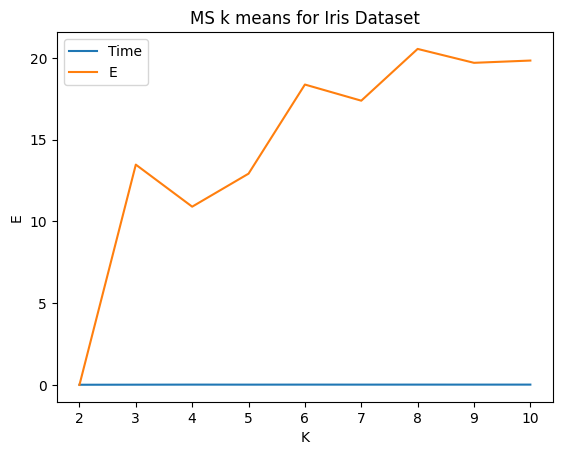

In [ ]:
plt.plot(iris_df_mskm['K'], iris_df_mskm['time'], label='Time')
plt.plot(iris_df_mskm['K'], iris_df_mskm['E'], label='E')
plt.title('MS k means for Iris Dataset')
plt.xlabel('K')
plt.ylabel('E')
plt.legend()
plt.show()

## 2.3 Alghorithm 4

In [ ]:
iris_alg4_centers , _ = algorithm_4(iris , 10 , 0.05)
print(f'the good k for iris is : {len(iris_alg4_centers)}')

the good k for iris is : 4


In [ ]:
center , label = mgkm(iris ,4)

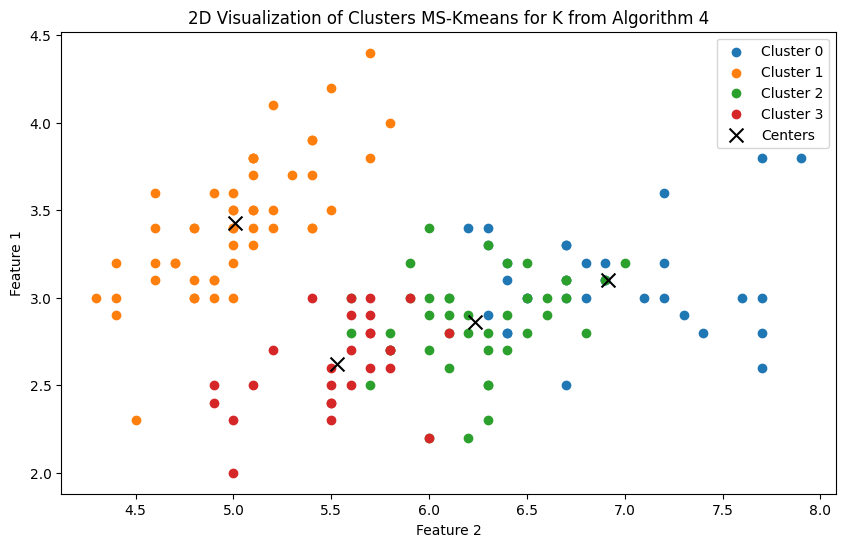

In [ ]:
d2_plot(label , center , iris)

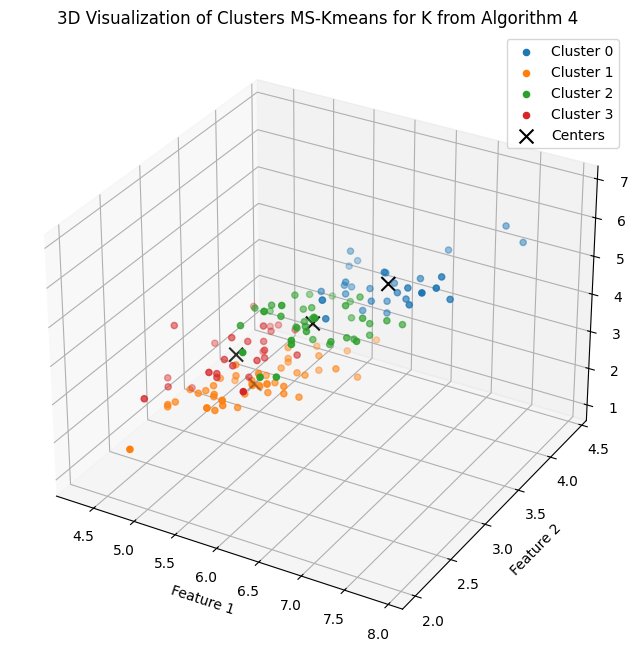

In [ ]:
d3_plot(label , center , iris)

## 2.4 Elbow method vs algorithm 4

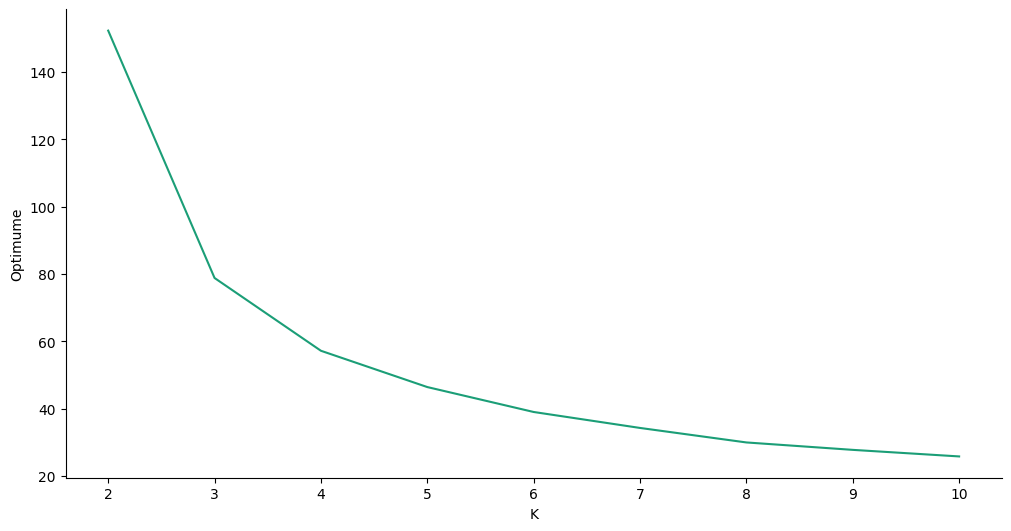

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['K']
  ys = series['Optimume']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = iris_df_gkm.sort_values('K', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('K')
_ = plt.ylabel('Optimume')

## 2.5 GKM

In [ ]:

iris_df_gkm = test_gkm(iris , iris_f_opt , k_values1)
iris_df_gkm

,K,Optimume,E,time
0,2,152.348,0.00,0.197966
1,3,78.851,0.00,0.403620
2,4,57.228,0.00,0.638820
3,5,46.446,0.00,0.831842
4,6,39.040,0.00,1.367445
5,7,34.298,0.02,1.686395
6,8,29.989,0.00,2.017726
7,9,27.786,0.01,1.699482
8,10,25.834,0.51,1.825534


## 2.6 Custom


In [32]:
iris_df_custom = test_custom(iris,iris_f_opt , k_values1)
iris_df_custom

,K,Optimume,E,time
0,2,152.348,0.00,0.045277
1,3,78.851,0.00,0.082199
2,4,57.228,24.84,0.194630
3,5,46.446,7.60,0.250814
4,6,39.040,22.77,0.355047
5,7,34.298,7.93,0.301489
6,8,29.989,7.99,0.315334
7,9,27.786,14.45,0.366080
8,10,25.834,4.99,0.406733


## 2.7 Fast GKM


In [31]:
iris_df_fast = test_fast(iris,iris_f_opt , k_values1)
iris_df_fast

,K,Optimume,E,time
0,2,152.348,0.00,0.015913
1,3,78.851,0.01,0.017110
2,4,57.228,0.05,0.025381
3,5,46.446,0.54,0.033898
4,6,39.040,1.44,0.039199
5,7,34.298,3.17,0.047822
6,8,29.989,1.71,0.078970
7,9,27.786,2.85,0.066846
8,10,25.834,3.56,0.059067


# 3) Liver Disorders

In [32]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
file_path = '/content/drive/My Drive/Modified Global Kmeans/Data sets/Real Data Sets/liver.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()
data = [line.strip().split() for line in lines]
df_liver = pd.DataFrame(data)
df_liver =df_liver.astype(float)
df_liver = df_liver.to_numpy()
df_liver

array([[85., 64., 59., 32., 23.,  0.],
       [86., 54., 33., 16., 54.,  0.],
       [91., 78., 34., 24., 36.,  0.],
       ...,
       [98., 77., 55., 35., 89., 15.],
       [91., 68., 27., 26., 14., 16.],
       [98., 99., 57., 45., 65., 20.]])

In [34]:
liver_f_opt = [0.42398e6,0.21826e6,0.12768e6,
               0.97474e5,0.81820e5,0.70419e5,
               0.61143e5,0.47832e5,0.39581e5]

## 3.1 MGKM

In [ ]:
liver_df_mgkm = test_mgkm(df_liver,liver_f_opt , k_values2)
liver_df_mgkm

,K,Optimume,E,time
0,2,423980.0,0.00,0.050587
1,5,218260.0,0.08,0.199133
2,10,127680.0,0.01,0.697874
3,15,97474.0,0.00,1.288532
4,20,81820.0,0.00,1.989568
5,25,70419.0,0.00,2.540035
6,30,61143.0,0.00,2.558681
7,40,47832.0,0.00,4.013727
8,50,39581.0,0.00,7.239292


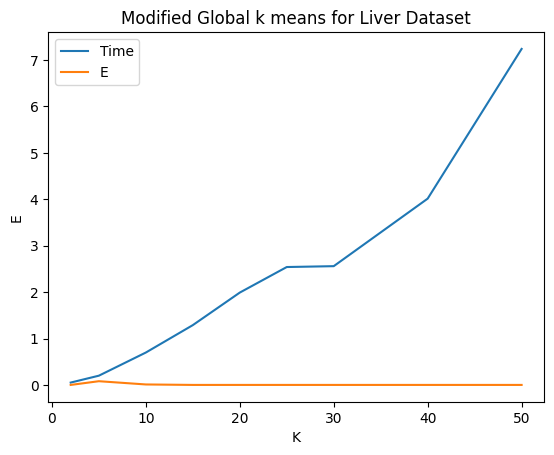

In [ ]:
plt.plot(liver_df_mgkm['K'], liver_df_mgkm['time'], label='Time')
plt.plot(liver_df_mgkm['K'], liver_df_mgkm['E'], label='E')
plt.title('Modified Global k means for Liver Dataset')
plt.xlabel('K')
plt.ylabel('E')
plt.legend()
plt.show()

## 3.2 MS Kmeans

In [ ]:
liver_df_mskm = test_km(df_liver,liver_f_opt , k_values2)
for i in range (1,200) :
    liver_df_mskm = test_km(df_liver,liver_f_opt , k_values2)

liber_df_mskm = liver_df_mskm/200
liver_df_mskm

,K,Optimume,E,time
0,2,423980.0,0.02,0.033445
1,5,218260.0,5.68,0.093612
2,10,127680.0,29.01,0.068702
3,15,97474.0,56.85,0.053501
4,20,81820.0,13.49,0.064097
5,25,70419.0,20.63,0.082074
6,30,61143.0,42.67,0.117043
7,40,47832.0,58.27,0.074261
8,50,39581.0,55.30,0.051011


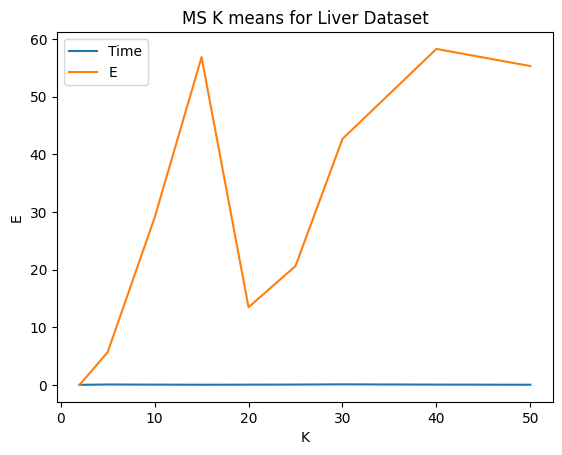

In [ ]:
plt.plot(liver_df_mskm['K'], liver_df_mskm['time'], label='Time')
plt.plot(liver_df_mskm['K'], liver_df_mskm['E'], label='E')
plt.title('MS K means for Liver Dataset')
plt.xlabel('K')
plt.ylabel('E')
plt.legend()
plt.show()

## 3.3 Algorithm 4

In [ ]:
c,_ = algorithm_4(df_liver , 100 , 0.05)

In [ ]:
len(c)

6

In [ ]:
center , label = mgkm(df_liver , 6)

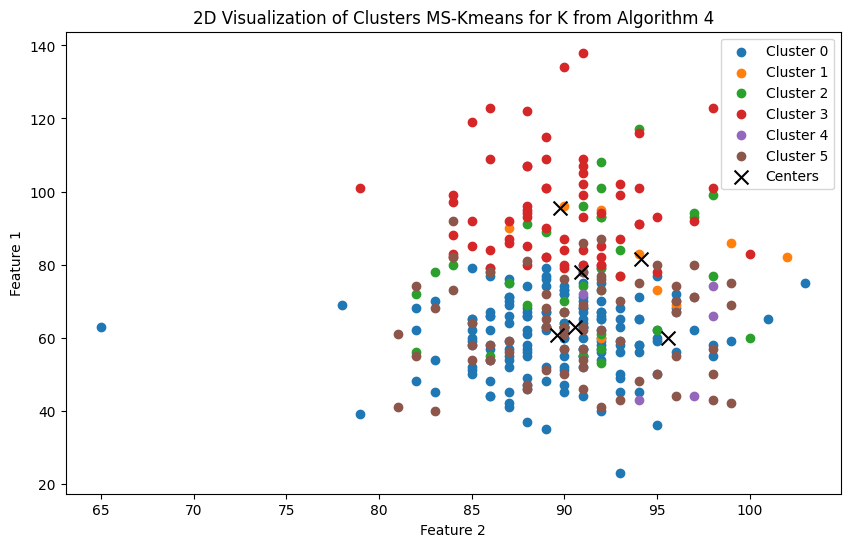

In [ ]:
d2_plot(label , center , df_liver)

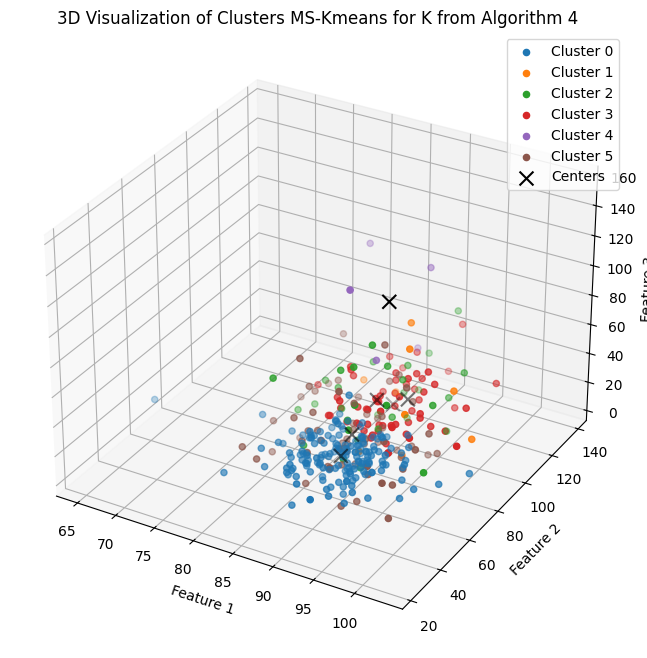

In [ ]:
d3_plot(label , center , df_liver)

## 3.4 Elbow method vs algorithm 4

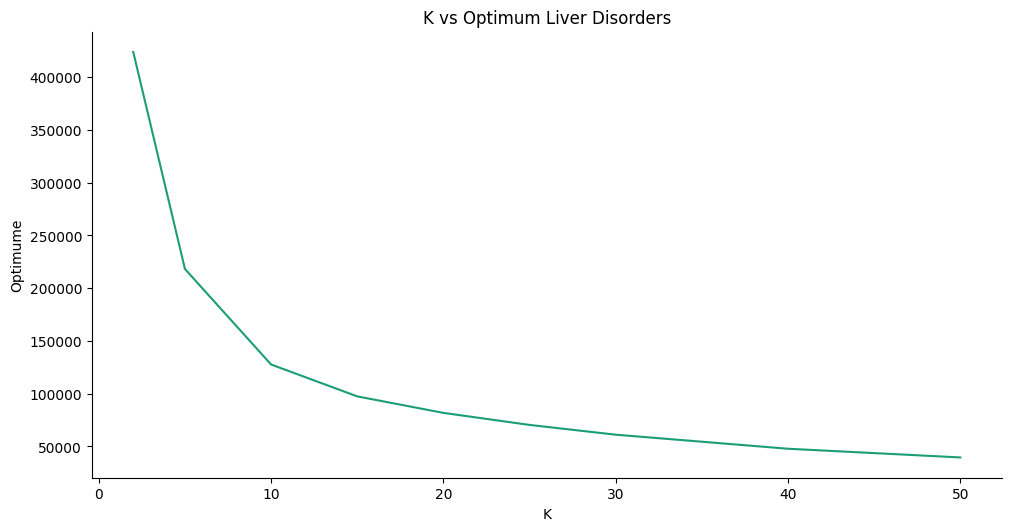

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['K']
  ys = series['Optimume']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = liver_df_mgkm.sort_values('K', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('K')
plt.title('K vs Optimum Liver Disorders')
_ = plt.ylabel('Optimume')

## 3.5 GKM

In [ ]:
test_gkm(df_liver , liver_f_opt , k_values2)

,K,Optimume,E,time
0,2,423980.0,0.00,0.592873
1,5,218260.0,0.00,2.745406
2,10,127680.0,0.06,7.874786
3,15,97474.0,0.42,9.706473
4,20,81820.0,1.67,14.074413
5,25,70419.0,2.28,20.089542
6,30,61143.0,1.74,20.690419
7,40,47832.0,0.99,27.388871
8,50,39581.0,3.13,33.354236


## 3.6 Custom


In [37]:
test_custom(df_liver , liver_f_opt , k_values2)

,K,Optimume,E,time
0,2,423980.0,0.00,0.043957
1,5,218260.0,0.08,0.444643
2,10,127680.0,6.15,0.991355
3,15,97474.0,7.12,1.980427
4,20,81820.0,8.18,1.698040
5,25,70419.0,9.70,2.176557
6,30,61143.0,6.85,2.644058
7,40,47832.0,14.88,3.899281
8,50,39581.0,21.67,6.541582


## 3.7 Fast GKM

In [35]:
test_fast(df_liver , liver_f_opt , k_values2)

,K,Optimume,E,time
0,2,423980.0,0.00,0.030551
1,5,218260.0,0.08,0.069494
2,10,127680.0,0.00,0.142411
3,15,97474.0,1.62,0.253201
4,20,81820.0,0.29,0.306812
5,25,70419.0,0.23,0.578425
6,30,61143.0,0.21,0.282652
7,40,47832.0,3.59,0.373879
8,50,39581.0,5.50,0.492324


# 4) TSPLIB1060

In [36]:
file_path = '/content/drive/My Drive/Modified Global Kmeans/Data sets/Real Data Sets/TSPLIB1060.txt'


In [37]:
import pandas as pd
with open(file_path, 'r') as file:
    lines = file.readlines()
data = [line.strip().split() for line in lines]
df_TSPLIB1060 = pd.DataFrame(data)
df_TSPLIB1060 =df_TSPLIB1060.astype(float)
df_TSPLIB1060 = df_TSPLIB1060.to_numpy()
df_TSPLIB1060

array([[4003.2 , 2997.9 ],
       [3602.88, 2498.25],
       [3953.16, 2848.  ],
       ...,
       [4053.24, 3447.58],
       [4253.4 , 3347.65],
       [4153.31, 3147.79]])

In [38]:
TSPLIB1060_fopt_list = [
    0.98319e10,  # k=2
    0.17548e10,  # k=10
    0.79179e9,   # k=20
    0.48125e9,   # k=30
    0.35312e9,   # k=40
    0.25551e9,   # k=50
    0.20443e9,   # k=60
    0.13535e9,   # k=80
    0.10041e9    # k=100
]



## 4.1 MGKM

In [ ]:
TSPLIB1060_df_mgkm =test_mgkm(df_TSPLIB1060,TSPLIB1060_fopt_list , k_values3)
TSPLIB1060_df_mgkm

,K,Optimume,E,time
0,2,9.831900e+09,0.00,0.159671
1,10,1.754800e+09,0.04,1.707699
2,20,7.917900e+08,0.42,4.783109
3,30,4.812500e+08,3.34,10.109418
4,40,3.531200e+08,0.00,15.431735
5,50,2.555100e+08,2.53,22.501454
6,60,2.044300e+08,0.00,30.970404
7,80,1.353500e+08,0.06,52.366698
8,100,1.004100e+08,0.00,77.449504


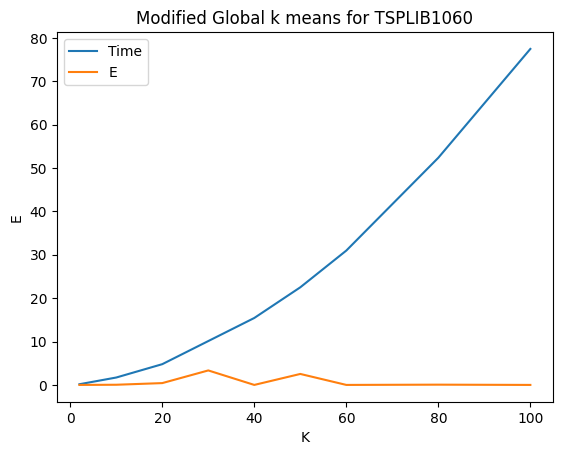

In [ ]:
plt.plot(TSPLIB1060_df_mgkm['K'], TSPLIB1060_df_mgkm['time'], label='Time')
plt.plot(TSPLIB1060_df_mgkm['K'], TSPLIB1060_df_mgkm['E'], label='E')
plt.title('Modified Global k means for TSPLIB1060')
plt.xlabel('K')
plt.ylabel('E')
plt.legend()
plt.show()

## 4.2 MS Kmeans

In [ ]:
TSPLIB1060_df_mskm = test_km(df_TSPLIB1060,TSPLIB1060_fopt_list , k_values3)
for i in range (1,200) :
    liver_df_mskm = test_km(df_TSPLIB1060,TSPLIB1060_fopt_list , k_values3)

TSPLIB1060_df_mskm = TSPLIB1060_df_mskm/200
TSPLIB1060_df_mskm

,K,Optimume,E,time
0,0.01,49159500.0,0.00000,0.000480
1,0.05,8774000.0,0.02635,0.001567
2,0.10,3958950.0,0.01245,0.001706
3,0.15,2406250.0,0.07905,0.000813
4,0.20,1765600.0,0.05620,0.001088
5,0.25,1277550.0,0.06450,0.002212
6,0.30,1022150.0,0.05425,0.001186
7,0.40,676750.0,0.10155,0.002310
8,0.50,502050.0,0.10335,0.001936


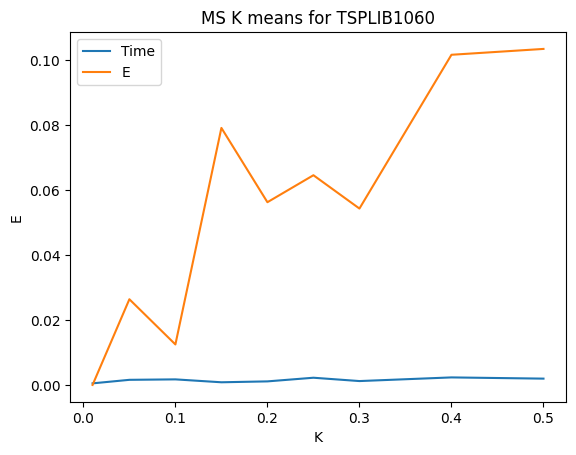

In [ ]:
plt.plot(TSPLIB1060_df_mskm['K'], TSPLIB1060_df_mskm['time'], label='Time')
plt.plot(TSPLIB1060_df_mskm['K'], TSPLIB1060_df_mskm['E'], label='E')
plt.title('MS K means for TSPLIB1060')
plt.xlabel('K')
plt.ylabel('E')
plt.legend()
plt.show()

## 4.3 Algorithm 4

In [ ]:
center , _ = algorithm_4(df_TSPLIB1060 , 100)
len(c)

6

In [ ]:
center , label = mgkm(df_TSPLIB1060 , 6)

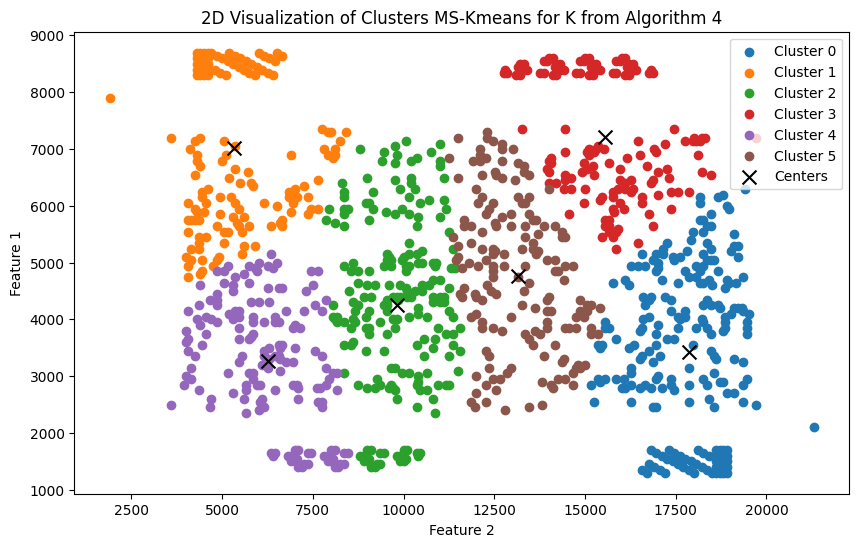

In [ ]:
d2_plot(label , center , df_TSPLIB1060)

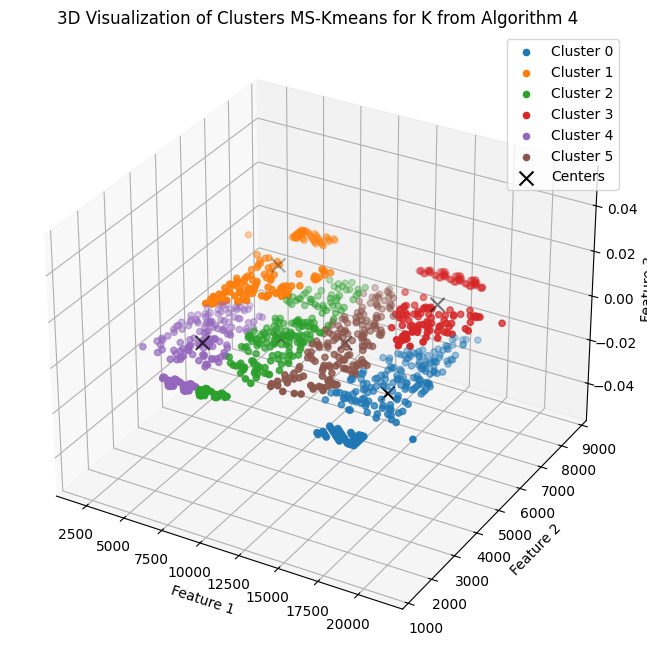

In [ ]:
d3_plot(label , center , df_TSPLIB1060)

## 4.4 Elbow method vs algorithm 4

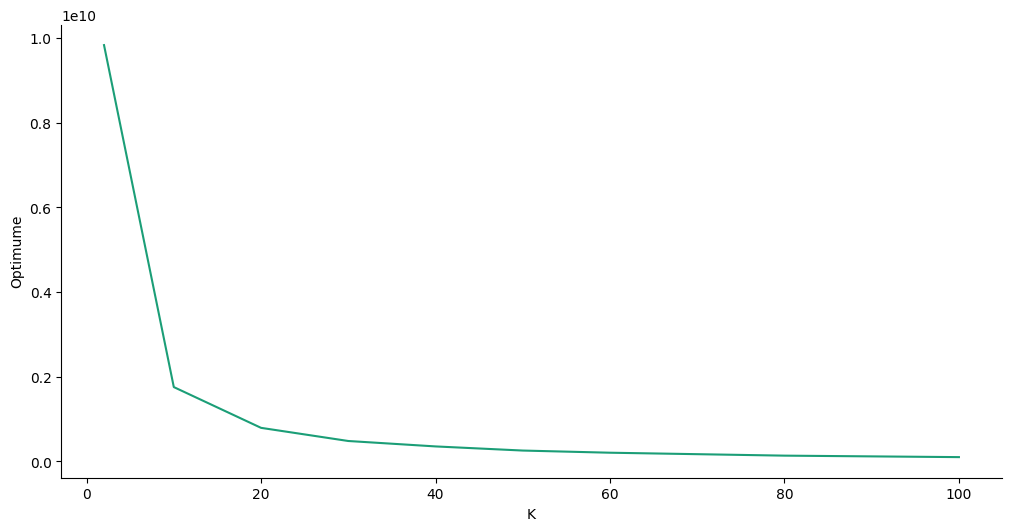

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['K']
  ys = series['Optimume']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = TSPLIB1060_df_mgkm.sort_values('K', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('K')
_ = plt.ylabel('Optimume')

## 4.5 GKM

In [ ]:
test_gkm(df_TSPLIB1060 , TSPLIB1060_fopt_list , k_values3)

,K,Optimume,E,time
0,2,9.831900e+09,0.00,2.729697
1,10,1.754800e+09,0.00,31.324141
2,20,7.917900e+08,0.04,64.869833
3,30,4.812500e+08,0.12,115.002570
4,40,3.531200e+08,2.95,143.444993
5,50,2.555100e+08,0.43,158.269571
6,60,2.044300e+08,2.83,200.053839
7,80,1.353500e+08,4.39,282.831285
8,100,1.004100e+08,3.76,368.279836


## 4.6 Custom

In [41]:
test_custom(df_TSPLIB1060 , TSPLIB1060_fopt_list , k_values3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (26) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (28) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (26) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (28) found smaller than n_clusters (29). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/

,K,Optimume,E,time
0,2,9.831900e+09,0.00,0.197082
1,10,1.754800e+09,0.54,2.574328
2,20,7.917900e+08,17.65,7.573617
3,30,4.812500e+08,5.80,9.421025
4,40,3.531200e+08,18.87,14.678304
5,50,2.555100e+08,36.23,20.500746
6,60,2.044300e+08,47.26,23.075213
7,80,1.353500e+08,70.44,34.799060
8,100,1.004100e+08,115.84,44.250868


## 4.7 Fast GKM

In [39]:
test_fast(df_TSPLIB1060 , TSPLIB1060_fopt_list , k_values3)

,K,Optimume,E,time
0,2,9.831900e+09,0.00,0.035889
1,10,1.754800e+09,0.25,0.272404
2,20,7.917900e+08,0.42,0.565796
3,30,4.812500e+08,3.34,0.888233
4,40,3.531200e+08,1.14,1.156447
5,50,2.555100e+08,3.10,1.476189
6,60,2.044300e+08,0.72,1.720070
7,80,1.353500e+08,0.49,2.354555
8,100,1.004100e+08,0.02,4.407688


# 5) Heart Disease

In [ ]:
file_path = '/content/drive/My Drive/Modified Global Kmeans/Data sets/Real Data Sets/HeartDisease.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()
data = [line.strip().split() for line in lines]
df_Heart = pd.DataFrame(data)
df_Heart =df_Heart.astype(float)
df_Heart = df_Heart.to_numpy()
df_Heart

array([[63.,  1.,  1., ...,  3.,  0.,  6.],
       [37.,  1.,  3., ...,  3.,  0.,  3.],
       [41.,  0.,  2., ...,  1.,  0.,  3.],
       ...,
       [68.,  1.,  4., ...,  2.,  2.,  7.],
       [57.,  1.,  4., ...,  2.,  1.,  7.],
       [57.,  0.,  2., ...,  2.,  1.,  3.]])

In [ ]:
heart_f_opt =[
    0.59890e6,  # k = 2
    0.32792e6,  # k = 5
    0.20222e6,  # k = 10
    0.14771e6,  # k = 15
    0.11778e6,  # k = 20
    0.10213e6,  # k = 25
    0.88795e5,  # k = 30
    0.68645e5,  # k = 40
    0.55894e5   # k = 50
]

## 5.1 MGKM

In [ ]:
heart_df_mgkm = test_mgkm(df_Heart,heart_f_opt , k_values2)
heart_df_mgkm

,K,Optimume,E,time
0,2,598900.0,0.00,0.063769
1,5,327920.0,0.54,0.174996
2,10,202220.0,1.93,0.620270
3,15,147710.0,0.69,1.292193
4,20,117780.0,1.34,2.048455
5,25,102130.0,0.00,2.306600
6,30,88795.0,0.31,2.623723
7,40,68645.0,0.00,4.293853
8,50,55894.0,0.00,7.823734


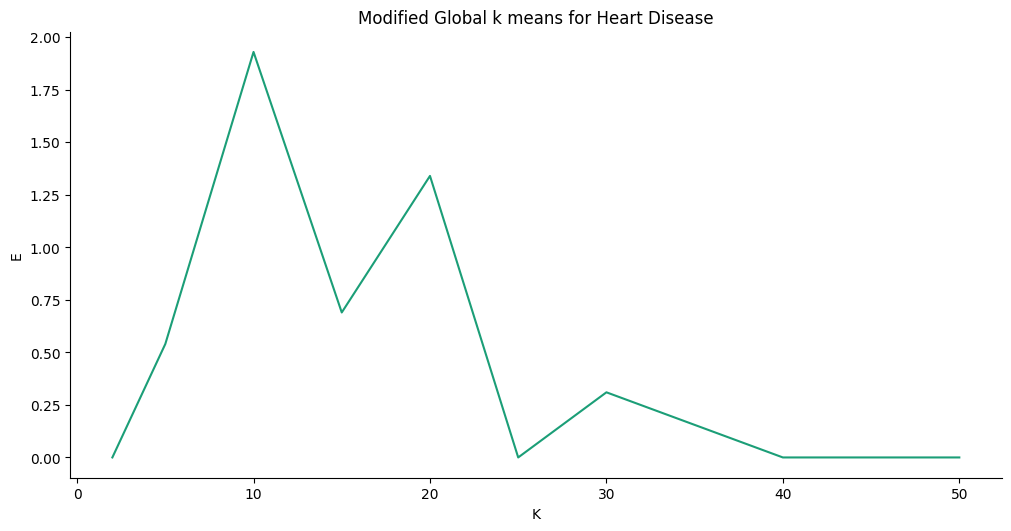

In [ ]:
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['K']
  ys = series['E']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = heart_df_mgkm.sort_values('K', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('K')
plt.title('Modified Global k means for Heart Disease')
_ = plt.ylabel('E')

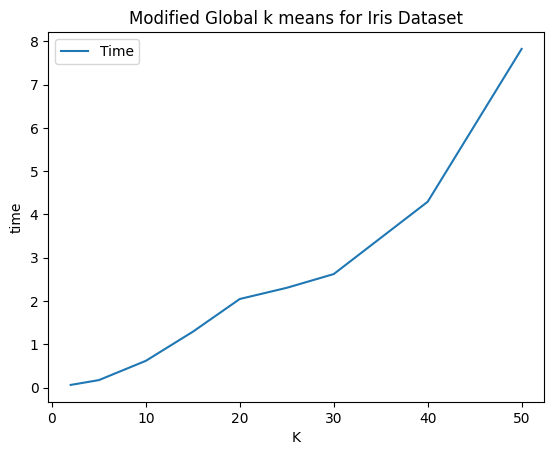

In [ ]:
plt.plot(heart_df_mgkm['K'], heart_df_mgkm['time'], label='Time')
plt.title('Modified Global k means for Iris Dataset')
plt.xlabel('K')
plt.ylabel('time')
plt.legend()
plt.show()

## 5.2 MS Kmeans

In [ ]:
heart_df_mskm = test_km(df_Heart,heart_f_opt , k_values2)
for i in range (1,100) :
    heart_df_mskm+= test_km(df_Heart,heart_f_opt , k_values2)

heart_df_mskm = heart_df_mskm/100
heart_df_mskm

,K,Optimume,E,time
0,2.0,598900.0,0.0000,0.040738
1,5.0,327920.0,6.6998,0.058124
2,10.0,202220.0,7.1911,0.065395
3,15.0,147710.0,14.3163,0.058592
4,20.0,117780.0,22.6280,0.058635
5,25.0,102130.0,25.8813,0.056349
6,30.0,88795.0,28.4037,0.053573
7,40.0,68645.0,35.4506,0.049715
8,50.0,55894.0,46.1896,0.047712


# Breast Cancer

In [ ]:
file_path = '/content/drive/My Drive/Modified Global Kmeans/Data sets/Real Data Sets/breast.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()
data = [line.strip().split() for line in lines]
df_breast = pd.DataFrame(data)
df_breast =df_breast.astype(float)
df_breast = df_breast.to_numpy()
df_breast

array([[ 1.,  1.,  2., ...,  2.,  1.,  1.],
       [ 5.,  7.,  7., ...,  3.,  4.,  1.],
       [ 5.,  3.,  1., ...,  2.,  1.,  1.],
       ...,
       [ 7.,  4.,  4., ...,  6.,  9.,  1.],
       [ 8.,  4.,  7., ...,  3.,  9.,  2.],
       [ 8., 10.,  3., ...,  3., 10.,  1.]])

In [ ]:
breast_f_opt =[
    0.19323e5,  # k = 2
    0.13705e5,  # k = 5
    0.10216e5,  # k = 10
    0.87813e4,  # k = 15
    0.77855e4,  # k = 20
    0.69682e4,  # k = 25
    0.64415e4,  # k = 30
    0.56171e4,  # k = 40
    0.49896e4   # k = 50
]

In [ ]:
breast_df_mgkm = test_mgkm(df_breast,breast_f_opt , k_values2)
breast_df_mgkm

,K,Optimume,E,time
0,2,19323.0,0.00,0.195347
1,5,13705.0,1.86,0.795561
2,10,10216.0,0.02,2.505923
3,15,8781.3,0.04,4.769845
4,20,7785.5,0.00,11.699120
5,25,6968.2,0.00,11.698370
6,30,6441.5,0.00,10.207879
7,40,5617.1,0.00,15.980052
8,50,4989.6,0.00,24.445403


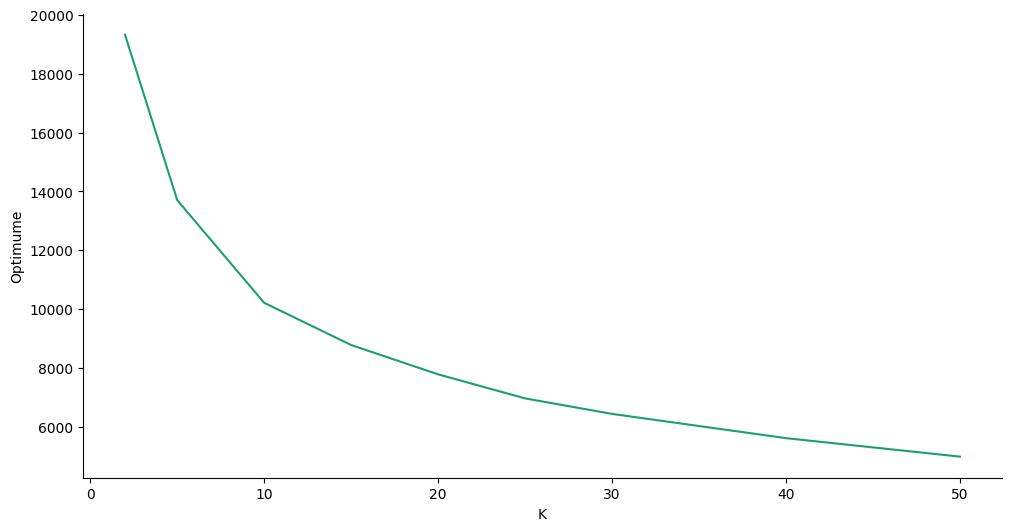

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['K']
  ys = series['Optimume']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = breast_df_mgkm.sort_values('K', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('K')
_ = plt.ylabel('Optimume')

# TSPLIB3080

In [ ]:
file_path = '/content/drive/My Drive/Modified Global Kmeans/Data sets/Real Data Sets/TSPLIB3038.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()
data = [line.strip().split() for line in lines]
df_TSPLIB3038 = pd.DataFrame(data)
df_TSPLIB3038 =df_TSPLIB3038.astype(float)
df_TSPLIB3038 = df_TSPLIB3038.to_numpy()
df_TSPLIB3038


array([[2830.,   40.],
       [2830.,   77.],
       [2830.,  114.],
       ...,
       [ -66., 3134.],
       [ -68., 3905.],
       [  38., 3941.]])

# Image Segmentation

# New Section

In [ ]:
x = df_TSPLIB1060

In [ ]:
c = distribute_centers_with_cosine_similarity(x ,100)

In [ ]:
kmeans = KMeans(n_clusters=100, init=c, n_init=1)
kmeans.fit(x)

KMeans(init=array([[11658.75856604,  4816.85680189],
       [11658.75659277,  4816.79401137],
       [11658.75068074,  4816.73146865],
       [11658.74085329,  4816.66942057],
       [11658.7271492 ,  4816.608112  ],
       [11658.70962255,  4816.54778489],
       [11658.68834252,  4816.48867733],
       [11658.66339309,  4816.4310226 ],
       [11658.63487272,  4816.37504821],
       [11658.60289396,  4816.32097509],
       [11658.56758303,  4816.2690...
       [11658.52907928,  4817.49422588],
       [11658.56758303,  4817.44458714],
       [11658.60289396,  4817.39262868],
       [11658.63487272,  4817.33855556],
       [11658.66339309,  4817.28258118],
       [11658.68834252,  4817.22492644],
       [11658.70962255,  4817.16581888],
       [11658.7271492 ,  4817.10549177],
       [11658.74085329,  4817.0441832 ],
       [11658.75068074,  4816.98213512],
       [11658.75659277,  4816.91959241]]),
       n_clusters=100, n_init=1)

In [ ]:
c = kmeans.cluster_centers_

In [ ]:
compute_fk(x,c)*len(df_TSPLIB1060)

145308975.32026067

In [ ]:
145308975.32026067-0.10041e9

44898975.320260674

In [ ]:
(44898975/0.10041e9)*100

44.715640872423066

# New Section

In [ ]:
import numpy as np
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances



def distribute_centers_cosine_distance(X, n_clusters):
    center = np.mean(X, axis=0)
    cosine_dists = cosine_distances(X, center.reshape(1, -1)).flatten()
    R = (np.max(cosine_dists))


    n_features = X.shape[1]
    centers = []
    angles = np.linspace(0, 2 * np.pi, n_clusters, endpoint=False)

    for i in range(n_clusters):
        direction = np.zeros(n_features)
        for j in range(n_features):
            direction[j] = np.cos(angles[i] + j * np.pi / n_features)

        direction = direction / np.linalg.norm(direction)
        new_center = center + R * direction
        centers.append(new_center)

    kmeans = KMeans(n_clusters=n_clusters , init = centers )
    kmeans.fit(X)
    return kmeans.cluster_centers_ , kmeans.labels_



In [ ]:
def test_km0 (x , f_opt , k_values) :
    z = []
    for i,k in enumerate(k_values):
        a = []
        a.append(k)
        time1 = time() # Starting time
        centers, _ = distribute_centers_cosine_distance(x, k)
        time2 = time() # End of time
        t_time = time2 - time1
        f_bar = compute_fk(x, centers) * len(x) # calculate f bar
        a.append(f_opt[i])
        e = abs((((f_bar - f_opt[i]) / f_opt[i]) * 100).round(2)) # calculate E
        a.append(e)
        a.append(t_time)
        z.append(a)

    df = pd.DataFrame(data=z , columns=['K' ,'Optimume', 'E' , 'time'])
    return df

In [ ]:
test_km0(iris,iris_f_opt , k_values1)

,K,Optimume,E,time
0,2,152.348,0.00,0.005221
1,3,78.851,0.01,0.002522
2,4,57.228,0.27,0.002733
3,5,46.446,0.00,0.002633
4,6,39.040,0.64,0.002745
5,7,34.298,5.11,0.003096
6,8,29.989,2.71,0.002962
7,9,27.786,3.03,0.003193
8,10,25.834,0.74,0.003158


In [ ]:
test_km0(df_liver , liver_f_opt , k_values2)

,K,Optimume,E,time
0,2,423980.0,0.02,0.004534
1,5,218260.0,3.88,0.005625
2,10,127680.0,24.23,0.003397
3,15,97474.0,10.35,0.003626
4,20,81820.0,17.17,0.003062
5,25,70419.0,21.89,0.003829
6,30,61143.0,27.35,0.003243
7,40,47832.0,33.56,0.003560
8,50,39581.0,28.71,0.004137
